###### Plamadealov, Home assignment #2
###### VaR
###### ВТБ и после IPO Группа Астра

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', '{:.4f}'.format)

In [7]:
%pip install apimoex
import apimoex
import requests


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


###### MOEX даёт данные с 2013 года, добавил импорт из Финама, но проблема в том, что Финам даёт данные в текущих величинах, а MOEX в исторических, до и после сплита различающихся. Решаем.

In [31]:
def load_finam_csv(filepath):
    df = pd.read_csv(
        filepath,
        sep=';',
        names=['DATE', 'TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'],
        skiprows=1,
        dtype={'DATE': str}
    )
    df['DATE'] = df['DATE'].str.zfill(6)
    df['DATE'] = pd.to_datetime(df['DATE'], format='%y%m%d')
    df.set_index('DATE', inplace=True)
    df = df.drop(columns=['TIME'])
    return df

df_2007_2008 = load_finam_csv('VTBR_050101_081231.csv')
df_2008_2012 = load_finam_csv('VTBR_080101_121231.csv')
df_2013_q1 = load_finam_csv('VTBR_130101_130324.csv')

with requests.Session() as session:
    data = apimoex.get_board_history(
        session, 
        security='VTBR',
        start='2013-01-01',
        end='2025-12-31'
    )
    df_moex = pd.DataFrame(data)

df_moex['TRADEDATE'] = pd.to_datetime(df_moex['TRADEDATE'])
df_moex.set_index('TRADEDATE', inplace=True)
df_moex = df_moex[['CLOSE', 'VOLUME']]
df_vtb = pd.concat([df_2007_2008[['CLOSE', 'VOLUME']], 
                    df_2008_2012[['CLOSE', 'VOLUME']], 
                    df_2013_q1[['CLOSE', 'VOLUME']],
                    df_moex])

df_vtb = df_vtb[~df_vtb.index.duplicated(keep='first')]
df_vtb = df_vtb.sort_index()

df_vtb.head()

,CLOSE,VOLUME
2007-05-28,708.0000,844488.0000
2007-05-29,697.5000,974955.6000
2007-05-30,692.5000,939662.4000
2007-05-31,724.0000,819905.4000
2007-06-01,726.0000,682291.0000


In [37]:
df_vtb['returns'] = np.log(df_vtb['CLOSE'] / df_vtb['CLOSE'].shift(1))
df_vtb['vol_ma100'] = df_vtb['returns'].rolling(window=100).std().shift(1)
df_vtb['vol_ma100_annual'] = df_vtb['vol_ma100'] * np.sqrt(252)

df_vtb[['CLOSE', 'returns', 'vol_ma100', 'vol_ma100_annual']].tail(10)

,CLOSE,returns,vol_ma100,vol_ma100_annual
2025-12-17,72.0000,-0.0014,0.0149,0.2361
2025-12-18,73.3200,0.0182,0.0149,0.2359
2025-12-19,73.0700,-0.0034,0.0150,0.2377
2025-12-22,71.1900,-0.0261,0.0149,0.2368
2025-12-23,71.8800,0.0096,0.0151,0.2402
2025-12-24,71.6000,-0.0039,0.0149,0.2361
2025-12-25,71.4000,-0.0028,0.0148,0.2356
2025-12-26,72.9200,0.0211,0.0148,0.2356
2025-12-29,72.1700,-0.0103,0.0150,0.2374
2025-12-30,72.2200,0.0007,0.0149,0.2371


###### Коррекция на учёт сплита

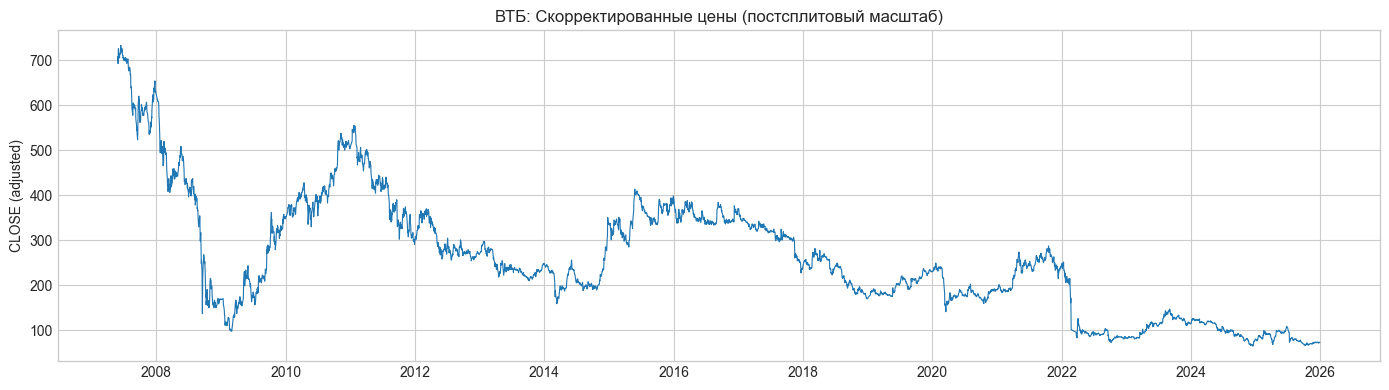

In [38]:
split_date = '2024-07-15'
split_ratio = 5000
moex_start = '2013-03-26'

df_vtb['CLOSE_ADJ'] = df_vtb['CLOSE'].copy()

mask = (df_vtb.index >= moex_start) & (df_vtb.index < split_date)
df_vtb.loc[mask, 'CLOSE_ADJ'] = df_vtb.loc[mask, 'CLOSE'] * split_ratio

df_vtb['returns'] = np.log(df_vtb['CLOSE_ADJ'] / df_vtb['CLOSE_ADJ'].shift(1))
df_vtb = df_vtb.dropna(subset=['CLOSE_ADJ'])

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_vtb.index, df_vtb['CLOSE_ADJ'], linewidth=0.8)
ax.set_ylabel('CLOSE (adjusted)')
ax.set_title('ВТБ: Скорректированные цены (постсплитовый масштаб)')
plt.tight_layout()
plt.show()

###### 1.1. MA100

count   4406.0000
mean       0.3690
std        0.2205
min        0.1510
25%        0.2392
50%        0.3103
75%        0.4012
max        1.3803
Name: vol_ma100_annual, dtype: float64


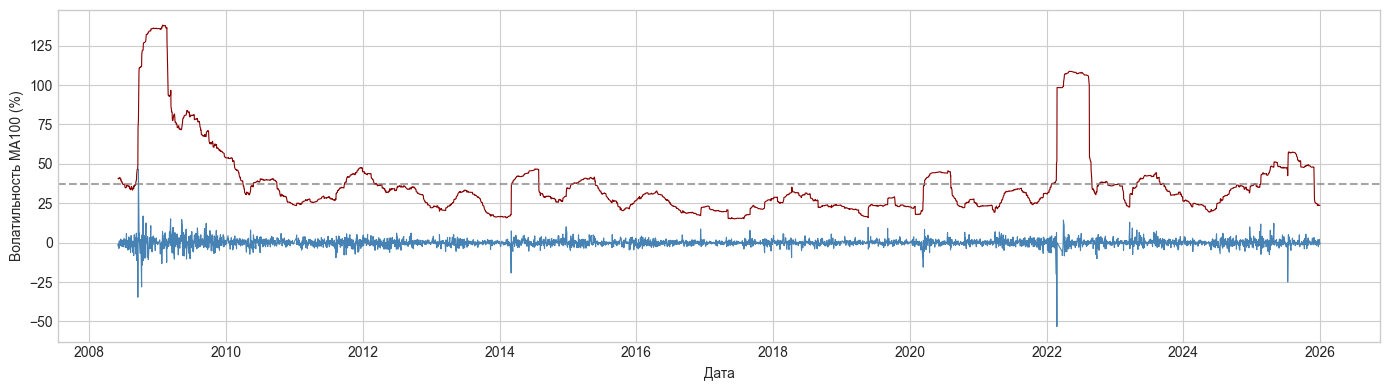

In [49]:
df_vtb['vol_ma100'] = df_vtb['returns'].rolling(window=100).std().shift(1)
df_vtb['vol_ma100_annual'] = df_vtb['vol_ma100'] * np.sqrt(252)

df_analysis = df_vtb.iloc[252:].copy()
print(df_analysis['vol_ma100_annual'].describe())

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_analysis.index, df_analysis['vol_ma100_annual'] * 100, color='darkred', linewidth=0.8)
ax.plot(df_analysis.index, df_analysis['returns'] * 100, color='steelblue', linewidth=0.8, label='Return')
ax.set_ylabel('Волатильность MA100 (%)')
ax.set_xlabel('Дата')
ax.axhline(y=df_analysis['vol_ma100_annual'].mean() * 100, color='gray', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

###### 1.2. MA250

count   4406.0000
mean       0.3826
std        0.1919
min        0.1815
25%        0.2716
50%        0.3257
75%        0.3817
max        1.0451
Name: vol_ma250_annual, dtype: float64


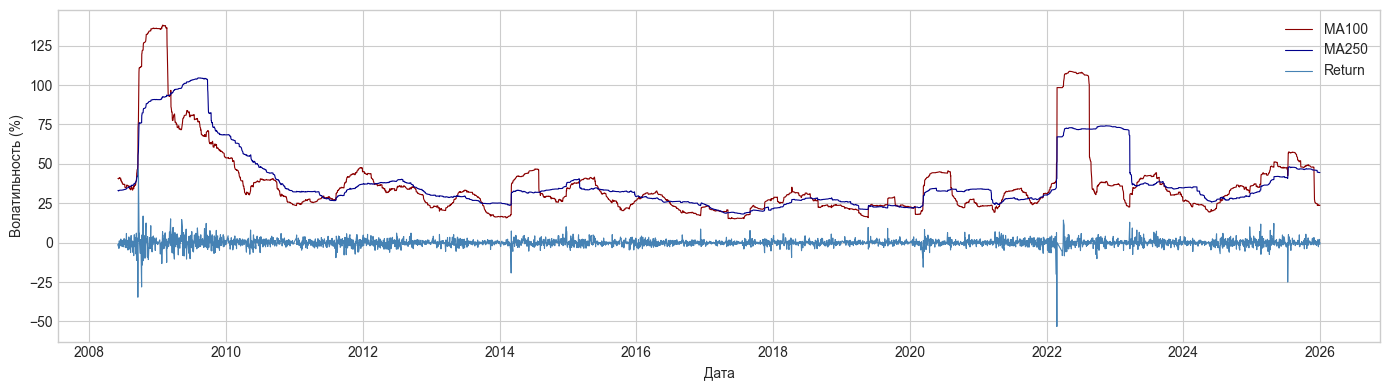

In [50]:
df_vtb['vol_ma250'] = df_vtb['returns'].rolling(window=250).std().shift(1)
df_vtb['vol_ma250_annual'] = df_vtb['vol_ma250'] * np.sqrt(252)

df_analysis = df_vtb.iloc[252:].copy()
print(df_analysis['vol_ma250_annual'].describe())

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_analysis.index, df_analysis['vol_ma100_annual'] * 100, color='darkred', linewidth=0.8, label='MA100')
ax.plot(df_analysis.index, df_analysis['vol_ma250_annual'] * 100, color='darkblue', linewidth=0.8, label='MA250')
ax.plot(df_analysis.index, df_analysis['returns'] * 100, color='steelblue', linewidth=0.8, label='Return')
ax.set_ylabel('Волатильность (%)')
ax.set_xlabel('Дата')
ax.legend()

plt.tight_layout()
plt.show()

###### 1.3. EWMA (lambda = 0.94)

EWMA (lambda=0.94) годовая волатильность:
count   4406.0000
mean       0.3517
std        0.2460
min        0.1036
25%        0.2221
50%        0.2922
75%        0.3853
max        2.4341
Name: vol_ewma_annual, dtype: float64


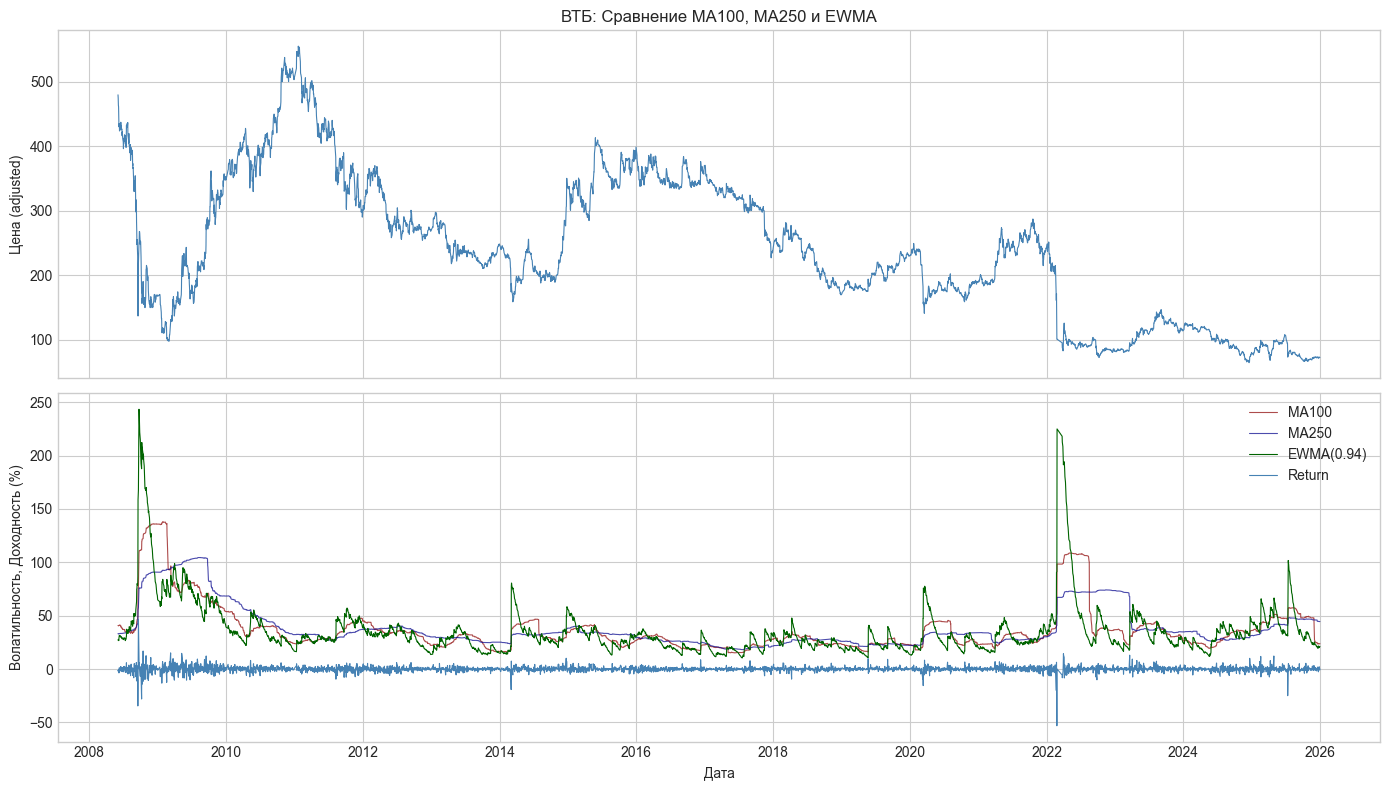

In [43]:
lambda_ = 0.94
returns = df_vtb['returns'].values

initial_var = np.var(returns[1:101], ddof=1)

ewma_var = np.zeros(len(returns))
ewma_var[:101] = np.nan  # период инициализации
ewma_var[100] = initial_var

for t in range(101, len(returns)):
    ewma_var[t] = lambda_ * ewma_var[t-1] + (1 - lambda_) * returns[t-1]**2

df_vtb['vol_ewma'] = np.sqrt(ewma_var)
df_vtb['vol_ewma_annual'] = df_vtb['vol_ewma'] * np.sqrt(252)

df_analysis = df_vtb.iloc[252:].copy()
print("EWMA (lambda=0.94) годовая волатильность:")
print(df_analysis['vol_ewma_annual'].describe())

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(df_analysis.index, df_analysis['CLOSE_ADJ'], color='steelblue', linewidth=0.8)
axes[0].set_ylabel('Цена (adjusted)')
axes[0].set_title('ВТБ: Сравнение MA100, MA250 и EWMA')

axes[1].plot(df_analysis.index, df_analysis['vol_ma100_annual'] * 100, color='darkred', linewidth=0.8, alpha=0.7, label='MA100')
axes[1].plot(df_analysis.index, df_analysis['vol_ma250_annual'] * 100, color='darkblue', linewidth=0.8, alpha=0.7, label='MA250')
axes[1].plot(df_analysis.index, df_analysis['vol_ewma_annual'] * 100, color='darkgreen', linewidth=0.8, label='EWMA(0.94)')
axes[1].plot(df_analysis.index, df_analysis['returns'] * 100, color='steelblue', linewidth=0.8, label='Return')
axes[1].set_ylabel('Волатильность, Доходность (%)')
axes[1].set_xlabel('Дата')
axes[1].legend()

plt.tight_layout()
plt.show()

###### Comment the differences. Which approach would you choose? Motivate your choice

Заметно, что
- амплитуда изменений EWMA наивысшая, далее MA100, далее MA250. Т.о. выстраиваясь по величине реакции на резкие изменения доходности;
- графику характерны кластеры повышенной волатильности и спокойствия: '08-09, '14-15, '22 (и ближайшие данные хорошо приоритизирует по отношению к остальным историческим данным именно EWMA);
- EWMA наиболее реактивна (быстрый рост в моменты наступления высокой волатильности, быстрый спад в моменты перехода к низкой);
- MA100 менее реактивен по сравнению с EWMA (запаздывание с началом и окончанием кластера). MA250 ещё менее реактивен.

Думаю, что мой выбор зависит от того, кекие предпочтения относительно показателя у меня формируются моим способом обращения с бумагами. Например, если я долгосрочный инвестор, и мне важен кешфлоу + какая-то сохранность капитала, то, вероятно, и MA250 мне нормально. Если важны действия, которые зависят от быстрого описания ближайшего «прошлого» и предполагаемого будущего, то ближе всего EWMA. Для VaR, конечно, использовал бы EWMA, она быстрее адаптируется к изменениям. А в версиях MA есть запаздывание, и это для нашей ситуации проблема — условия нестабильны.


##### NB, выплаты дивидендов не добавлял (в целом, величины не самые большие, но в продакшн-стайл, это, конечно, нужно было бы.)

###### 2.  Compute 5% VaR for 1-day horizon for each day over your sample period (except for the first year, which may be necessary for the initial calculations)

###### 2.1. Historical modeling with 1 year estimation period

In [63]:
window = 250
confidence_level = 0.05

def calc_historical_var(returns, window, alpha):
    var_series = -returns.rolling(window=window).quantile(alpha).shift(1)
    return var_series

def calc_var_delta_normal(volatility, alpha):
    z_alpha = stats.norm.ppf(1 - alpha)  # 1.645 для alpha=0.05
    return z_alpha * volatility

def plot_var_backtest(df, var_col, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(df.index, df['returns'] * 100, 
            color='steelblue', linewidth=0.5, alpha=0.7, label='Доходность')
    ax.plot(df.index, -df[var_col] * 100, 
            color='darkred', linewidth=1.0, label='VaR 5%')
    
    violations = df[df['returns'] < -df[var_col]]
    ax.scatter(violations.index, violations['returns'] * 100, 
               color='red', s=15, zorder=5, label=f'Violations (n={len(violations)})')
    
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.set_ylabel('Доходность / VaR (%)')
    ax.set_xlabel('Дата')
    ax.set_title(title)
    ax.legend(loc='lower left')
    return violations

def run_backtest(df, var_col, alpha):
    violations = df[df['returns'] < -df[var_col]]
    n_violations = len(violations)
    n_total = len(df)
    
    p_value_upper = 1 - binom.cdf(n_violations - 1, n_total, alpha)
    p_value_lower = binom.cdf(n_violations, n_total, alpha)
    p_value = 2 * min(p_value_upper, p_value_lower)
    
    return {
        'n_total': n_total,
        'n_violations': n_violations,
        'freq_observed': n_violations / n_total,
        'freq_expected': alpha,
        'p_value_upper': p_value_upper,
        'p_value': p_value,
        'conclusion': "Адекватна" if p_value > 0.05 else "Неадекватна",
        'violations_df': violations
    }

def calc_var_criteria(df, var_col, violations):
    # Реактивность
    reactivity = df[var_col].corr(df['returns'].abs())
    
    # Стабильность
    var_changes = df[var_col].diff()
    stability_std = var_changes.std()
    stability_pct = (var_changes.abs() > 0.01).mean() * 100
    
    # Точность (средний размер пробоя)
    if len(violations) > 0:
        avg_loss = violations['returns'].mean()
        avg_var = violations[var_col].mean()
        loss_ratio = -avg_loss / avg_var
    else:
        avg_loss, avg_var, loss_ratio = np.nan, np.nan, np.nan
    
    return {
        'reactivity': reactivity,
        'stability_std': stability_std,
        'stability_pct': stability_pct,
        'avg_loss': avg_loss,
        'avg_var': avg_var,
        'loss_ratio': loss_ratio
    }

def print_backtest_results(results, criteria, method_name):
    print("=" * 50)
    print(f"BACKTEST: {method_name}")
    print("=" * 50)
    print(f"Дней:                 {results['n_total']}")
    print(f"Нарушений:            {results['n_violations']}")
    print(f"Наблюдаемая частота:  {results['freq_observed']*100:.2f}%")
    print(f"Ожидаемая частота:    {results['freq_expected']*100:.2f}%")
    print(f"p-value (двухсьоронний):  {results['p_value']:.4f}")
    print(f"Вывод: Модель {results['conclusion']}")
    print("-" * 50)
    print(f"Реактивность (corr):  {criteria['reactivity']:.4f}")
    print(f"Стабильность (std):   {criteria['stability_std']*100:.4f}%")
    # Средний размер пробоя
    print(f"   Средняя доходность при пробое: {criteria['avg_loss']*100:.2f}%")
    print(f"   Средний VaR при пробое:        {criteria['avg_var']*100:.2f}%")
    print(f"Отношение loss/VaR:   {criteria['loss_ratio']:.2f}")
    print("=" * 50)

In [64]:
# Historical
df_vtb['VaR_hist'] = calc_historical_var(df_vtb['returns'], window, confidence_level)

df_analysis = df_vtb.iloc[252:].copy()

print(f"Период: {df_analysis.index.min().date()} - {df_analysis.index.max().date()}")
print(f"Дней : {len(df_analysis)}")
print(f"\nСтатистика VaR (5%):")
print(df_analysis['VaR_hist'].describe())

Период: 2008-06-02 - 2025-12-30
Дней : 4406

Статистика VaR (5%):
count   4406.0000
mean       0.0347
std        0.0160
min        0.0162
25%        0.0266
50%        0.0296
75%        0.0369
max        0.1005
Name: VaR_hist, dtype: float64


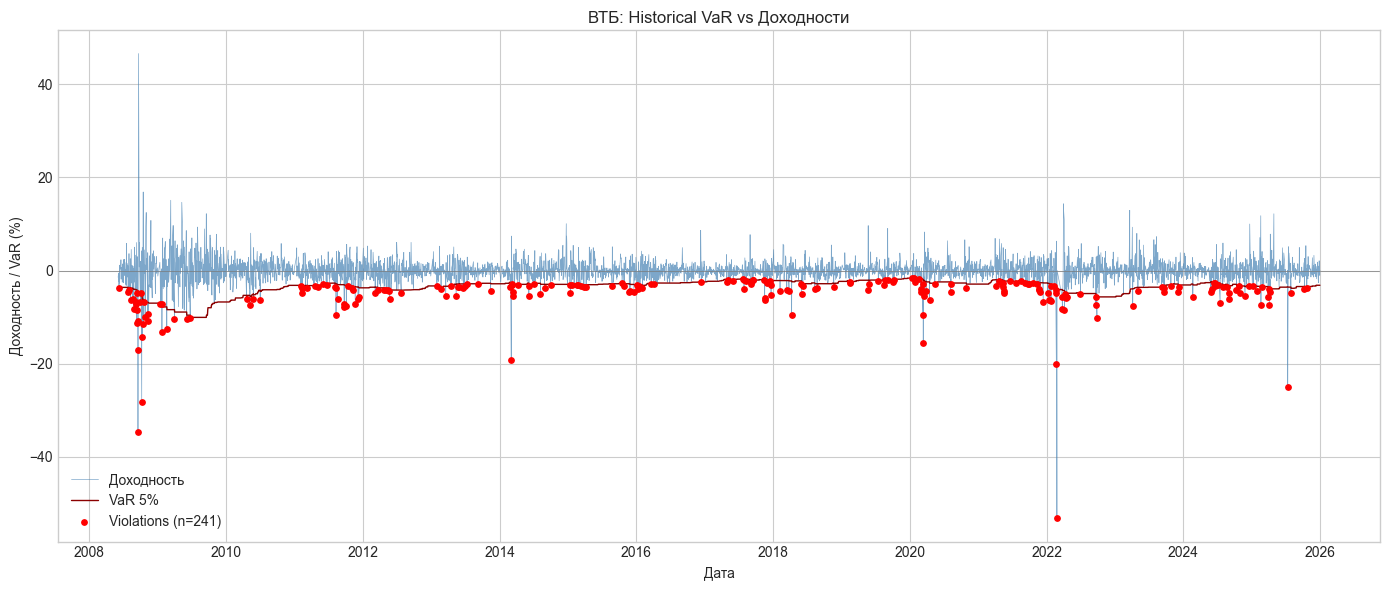


Дней: 4406
Нарушений: 241
Частота: 5.47%


In [65]:
fig, ax = plt.subplots(figsize=(14, 6))
violations_dn_ma100 = plot_var_backtest(df_analysis, 'VaR_hist', 
                                         'ВТБ: Historical VaR vs Доходности', ax)
plt.tight_layout()
plt.show()

print(f"\nДней: {len(df_analysis)}")
print(f"Нарушений: {len(violations_dn_ma100)}")
print(f"Частота: {len(violations_dn_ma100)/len(df_analysis)*100:.2f}%")

In [66]:
results_hist_var = run_backtest(df_analysis, 'VaR_hist', confidence_level)
criteria_hist_var = calc_var_criteria(df_analysis, 'VaR_hist', results_hist_var['violations_df'])

print_backtest_results(results_hist_var, criteria_hist_var, 'Historical VaR (%)')

BACKTEST: Historical VaR (%)
Дней:                 4406
Нарушений:            241
Наблюдаемая частота:  5.47%
Ожидаемая частота:    5.00%
p-value (двухсьоронний):  0.1654
Вывод: Модель Адекватна
--------------------------------------------------
Реактивность (corr):  0.2428
Стабильность (std):   0.0497%
   Средняя доходность при пробое: -5.38%
   Средний VaR при пробое:        3.19%
Отношение loss/VaR:   1.68


###### 2.2 Delta-normal approach using MA100 volatility

In [67]:
# Delta-normal
df_vtb['VaR_dn_ma100'] = calc_var_delta_normal(df_vtb['vol_ma100'], confidence_level)

df_analysis = df_vtb.iloc[252:].copy()

print(f"Период: {df_analysis.index.min().date()} - {df_analysis.index.max().date()}")
print(f"Дней: {len(df_analysis)}")
print(f"\nСтатистика VaR Delta-Normal MA100:")
print(df_analysis['VaR_dn_ma100'].describe())

Период: 2008-06-02 - 2025-12-30
Дней: 4406

Статистика VaR Delta-Normal MA100:
count   4406.0000
mean       0.0382
std        0.0228
min        0.0156
25%        0.0248
50%        0.0322
75%        0.0416
max        0.1430
Name: VaR_dn_ma100, dtype: float64


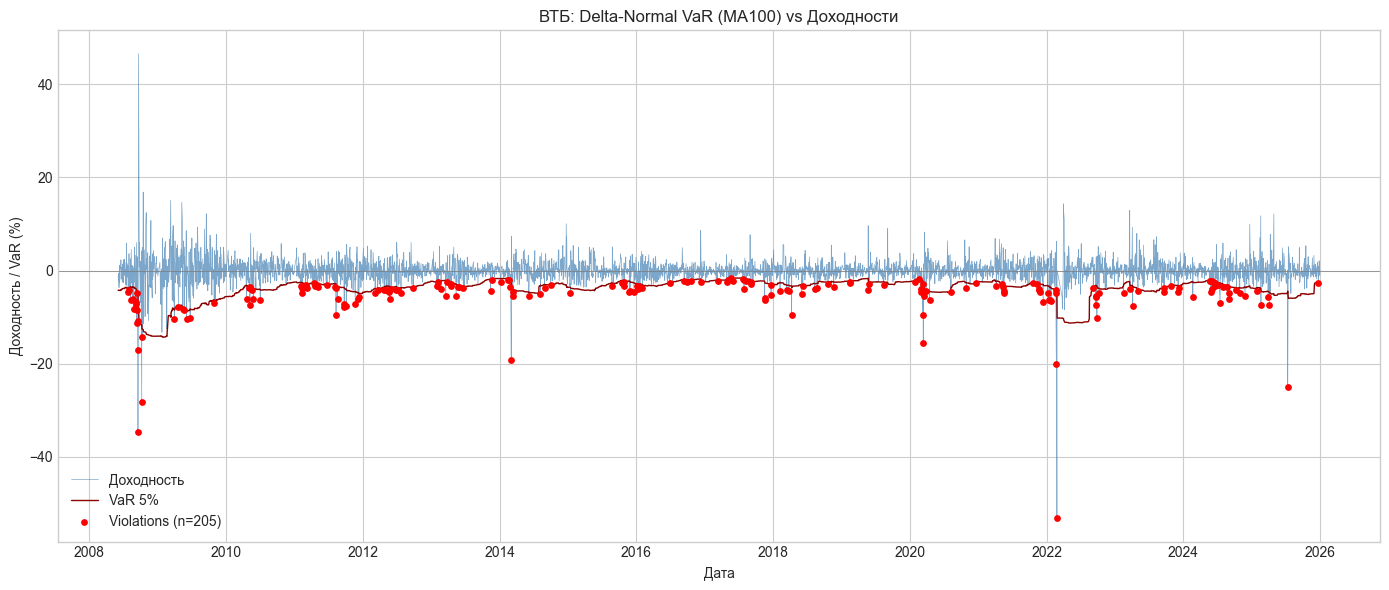


Дней: 4406
Нарушений: 205
Частота: 4.65%


In [68]:
fig, ax = plt.subplots(figsize=(14, 6))
violations_dn_ma100 = plot_var_backtest(df_analysis, 'VaR_dn_ma100', 
                                         'ВТБ: Delta-Normal VaR (MA100) vs Доходности', ax)
plt.tight_layout()
plt.show()

print(f"\nДней: {len(df_analysis)}")
print(f"Нарушений: {len(violations_dn_ma100)}")
print(f"Частота: {len(violations_dn_ma100)/len(df_analysis)*100:.2f}%")

In [69]:
results_dn_ma100 = run_backtest(df_analysis, 'VaR_dn_ma100', confidence_level)
criteria_dn_ma100 = calc_var_criteria(df_analysis, 'VaR_dn_ma100', results_dn_ma100['violations_df'])

print_backtest_results(results_dn_ma100, criteria_dn_ma100, 'Delta-Normal MA100')

BACKTEST: Delta-Normal MA100
Дней:                 4406
Нарушений:            205
Наблюдаемая частота:  4.65%
Ожидаемая частота:    5.00%
p-value (двухсьоронний):  0.3060
Вывод: Модель Адекватна
--------------------------------------------------
Реактивность (corr):  0.2715
Стабильность (std):   0.1529%
   Средняя доходность при пробое: -5.46%
   Средний VaR при пробое:        3.27%
Отношение loss/VaR:   1.67


###### 2.3. Delta-normal approach using MA250 volatility 


In [72]:
df_vtb['VaR_dn_ma250'] = calc_var_delta_normal(df_vtb['vol_ma250'], confidence_level)

df_analysis = df_vtb.iloc[252:].copy()

print(f"Период: {df_analysis.index.min().date()} - {df_analysis.index.max().date()}")
print(f"Дней: {len(df_analysis)}")
print(f"\nСтатистика VaR Delta-Normal MA250:")
print(df_analysis['VaR_dn_ma250'].describe())

Период: 2008-06-02 - 2025-12-30
Дней: 4406

Статистика VaR Delta-Normal MA250:
count   4406.0000
mean       0.0396
std        0.0199
min        0.0188
25%        0.0281
50%        0.0337
75%        0.0396
max        0.1083
Name: VaR_dn_ma250, dtype: float64


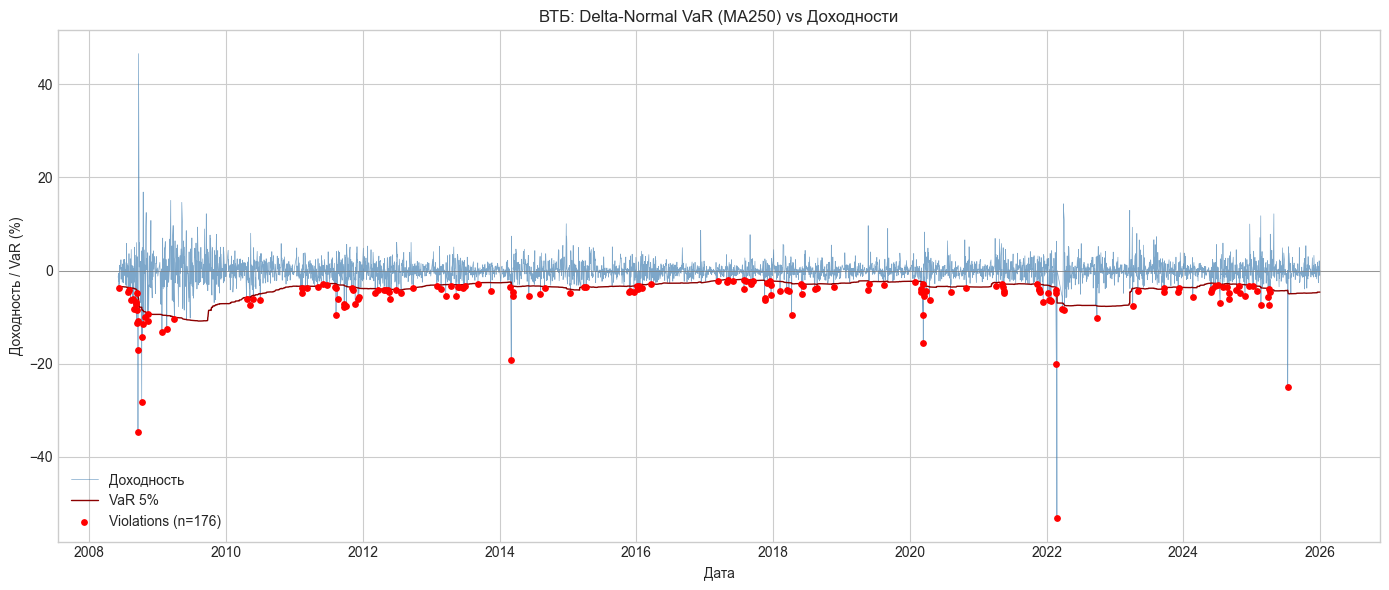


Дней: 4406
Нарушений: 176
Частота: 3.99%


In [73]:
fig, ax = plt.subplots(figsize=(14, 6))
violations_dn_ma250 = plot_var_backtest(df_analysis, 'VaR_dn_ma250', 
                                         'ВТБ: Delta-Normal VaR (MA250) vs Доходности', ax)
plt.tight_layout()
plt.show()

print(f"\nДней: {len(df_analysis)}")
print(f"Нарушений: {len(violations_dn_ma250)}")
print(f"Частота: {len(violations_dn_ma250)/len(df_analysis)*100:.2f}%")

In [74]:
results_dn_ma250 = run_backtest(df_analysis, 'VaR_dn_ma250', confidence_level)
criteria_dn_ma250 = calc_var_criteria(df_analysis, 'VaR_dn_ma250', results_dn_ma250['violations_df'])

print_backtest_results(results_dn_ma250, criteria_dn_ma250, 'Delta-Normal MA250')

BACKTEST: Delta-Normal MA250
Дней:                 4406
Нарушений:            176
Наблюдаемая частота:  3.99%
Ожидаемая частота:    5.00%
p-value (двухсьоронний):  0.0018
Вывод: Модель Неадекватна
--------------------------------------------------
Реактивность (corr):  0.2454
Стабильность (std):   0.0758%
   Средняя доходность при пробое: -6.03%
   Средний VaR при пробое:        3.56%
Отношение loss/VaR:   1.70


###### 2.4. Delta-normal approach using EWMA volatility 

In [75]:
df_vtb['VaR_dn_ewma'] = calc_var_delta_normal(df_vtb['vol_ewma'], confidence_level)

df_analysis = df_vtb.iloc[252:].copy()

print(f"Период: {df_analysis.index.min().date()} - {df_analysis.index.max().date()}")
print(f"Дней: {len(df_analysis)}")
print(f"\nСтатистика VaR Delta-Normal EWMA:")
print(df_analysis['VaR_dn_ewma'].describe())

Период: 2008-06-02 - 2025-12-30
Дней: 4406

Статистика VaR Delta-Normal EWMA:
count   4406.0000
mean       0.0364
std        0.0255
min        0.0107
25%        0.0230
50%        0.0303
75%        0.0399
max        0.2522
Name: VaR_dn_ewma, dtype: float64


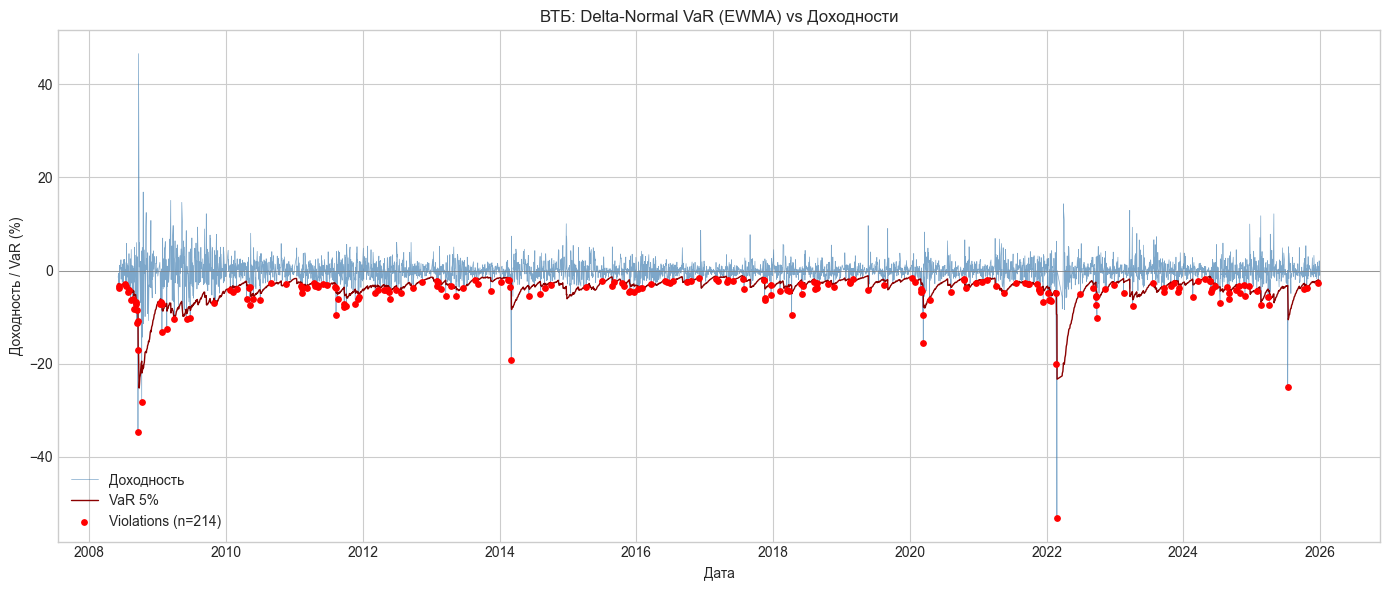


Дней: 4406
Нарушений: 214
Частота: 4.86%


In [76]:
fig, ax = plt.subplots(figsize=(14, 6))
violations_dn_ewma = plot_var_backtest(df_analysis, 'VaR_dn_ewma', 
                                        'ВТБ: Delta-Normal VaR (EWMA) vs Доходности', ax)
plt.tight_layout()
plt.show()

print(f"\nДней: {len(df_analysis)}")
print(f"Нарушений: {len(violations_dn_ewma)}")
print(f"Частота: {len(violations_dn_ewma)/len(df_analysis)*100:.2f}%")

In [77]:
results_dn_ewma = run_backtest(df_analysis, 'VaR_dn_ewma', confidence_level)
criteria_dn_ewma = calc_var_criteria(df_analysis, 'VaR_dn_ewma', results_dn_ewma['violations_df'])

print_backtest_results(results_dn_ewma, criteria_dn_ewma, 'Delta-Normal EWMA')

BACKTEST: Delta-Normal EWMA
Дней:                 4406
Нарушений:            214
Наблюдаемая частота:  4.86%
Ожидаемая частота:    5.00%
p-value (двухсьоронний):  0.6949
Вывод: Модель Адекватна
--------------------------------------------------
Реактивность (corr):  0.3812
Стабильность (std):   0.3813%
   Средняя доходность при пробое: -5.26%
   Средний VaR при пробое:        3.34%
Отношение loss/VaR:   1.58


###### 2.5 Все методы подсчёта VaR на одном графике с Доходностью

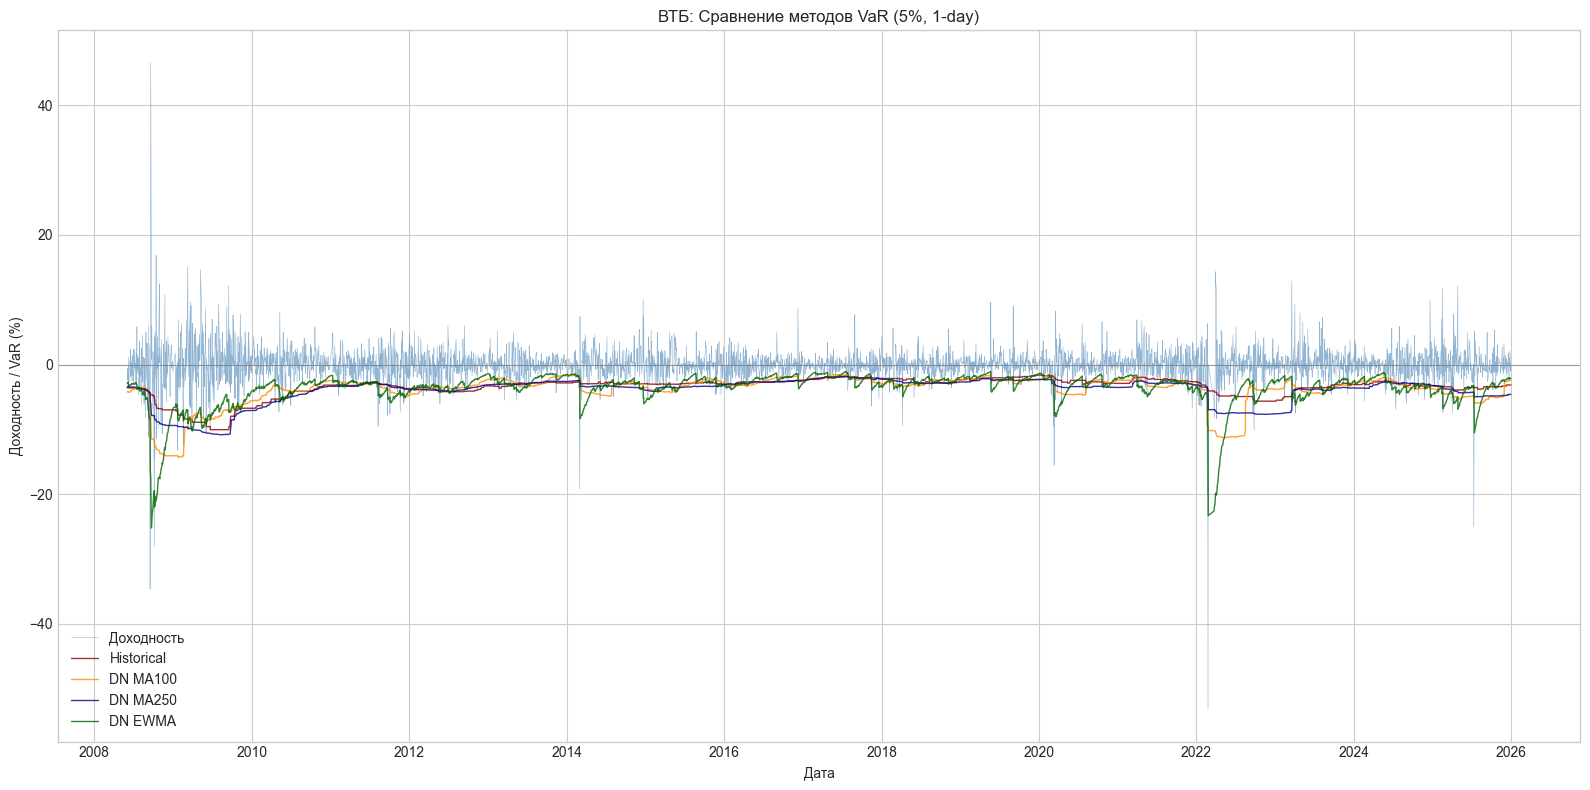

In [78]:
df_analysis = df_vtb.iloc[252:].copy()

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_analysis.index, df_analysis['returns'] * 100, 
        color='steelblue', linewidth=0.4, alpha=0.6, label='Доходность')

ax.plot(df_analysis.index, -df_analysis['VaR_hist'] * 100, 
        color='darkred', linewidth=1.0, alpha=0.8, label='Historical')
ax.plot(df_analysis.index, -df_analysis['VaR_dn_ma100'] * 100, 
        color='darkorange', linewidth=1.0, alpha=0.8, label='DN MA100')
ax.plot(df_analysis.index, -df_analysis['VaR_dn_ma250'] * 100, 
        color='darkblue', linewidth=1.0, alpha=0.8, label='DN MA250')
ax.plot(df_analysis.index, -df_analysis['VaR_dn_ewma'] * 100, 
        color='darkgreen', linewidth=1.0, alpha=0.8, label='DN EWMA')

ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.set_ylabel('Доходность / VaR (%)')
ax.set_xlabel('Дата')
ax.set_title('ВТБ: Сравнение методов VaR (5%, 1-day)')
ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

# TODO
###### Discuss which modeling approach to measure VaR you consider to be the best. 


###### 3. Download daily stock prices for Company 2 (see file Code, column D) for the period after its IPO. Make the retrospective analysis of VaR for the portfolio including 50% of each stock using the following approaches
###### (IPO Грпуппы Астра: 13/10/2023)

In [79]:
with requests.Session() as session:
    data_astra = apimoex.get_board_history(
        session, 
        security='ASTR',
        start='2023-10-13',  # IPO
        end='2025-12-31'
    )
    df_astra = pd.DataFrame(data_astra)

df_astra['TRADEDATE'] = pd.to_datetime(df_astra['TRADEDATE'])
df_astra.set_index('TRADEDATE', inplace=True)
df_astra = df_astra[['CLOSE', 'VOLUME']]
df_astra.columns = ['CLOSE_ASTRA', 'VOLUME_ASTRA']

df_astra['returns_astra'] = np.log(df_astra['CLOSE_ASTRA'] / df_astra['CLOSE_ASTRA'].shift(1)) # log returns

print(f"Астра: {df_astra.index.min().date()} - {df_astra.index.max().date()}")
print(f"Торговых дней: {len(df_astra)}")
df_astra.head()

Астра: 2023-10-13 - 2025-12-30
Торговых дней: 566


,CLOSE_ASTRA,VOLUME_ASTRA,returns_astra
TRADEDATE,,,
2023-10-13,466.2000,854970,NaN
2023-10-16,560.0000,19488378,0.1833
2023-10-17,531.6000,5739684,-0.0520
2023-10-18,506.0000,3334286,-0.0494
2023-10-19,502.7000,1643222,-0.0065


In [81]:
w_vtb = 0.5
w_astra = 0.5

df_portfolio = df_vtb[['returns', 'CLOSE_ADJ']].join(
    df_astra[['returns_astra', 'CLOSE_ASTRA']], 
    how='inner'
)
df_portfolio = df_portfolio.rename(columns={'returns': 'returns_vtb', 'CLOSE_ADJ': 'CLOSE_VTB'})
df_portfolio = df_portfolio.dropna()

df_portfolio['returns'] = w_vtb * df_portfolio['returns_vtb'] + w_astra * df_portfolio['returns_astra']

print(f"Период: {df_portfolio.index.min().date()} - {df_portfolio.index.max().date()}")
print(f"Дней: {len(df_portfolio)}")
print(f"\nДоходности портфеля:")
print(df_portfolio['returns'].describe())

Период: 2023-10-16 - 2025-12-30
Дней: 561

Доходности портфеля:
count   561.0000
mean     -0.0010
std       0.0188
min      -0.1392
25%      -0.0110
50%      -0.0013
75%       0.0093
max       0.1033
Name: returns, dtype: float64


In [82]:
# Historical VaR портфеля
# После IPO 550 дней, минус первый год (~250), год на анализ

window_portfolio = 250
df_portfolio['VaR_hist'] = calc_historical_var(df_portfolio['returns'], window_portfolio, confidence_level)

df_port_analysis = df_portfolio.iloc[window_portfolio:].copy()

print(f"Период: {df_port_analysis.index.min().date()} - {df_port_analysis.index.max().date()}")
print(f"Дней: {len(df_port_analysis)}")
print(f"\nVaR (5%):")
print(df_port_analysis['VaR_hist'].describe())

Период: 2024-10-14 - 2025-12-30
Дней: 311

VaR (5%):
count   311.0000
mean      0.0308
std       0.0020
min       0.0255
25%       0.0296
50%       0.0318
75%       0.0328
max       0.0336
Name: VaR_hist, dtype: float64


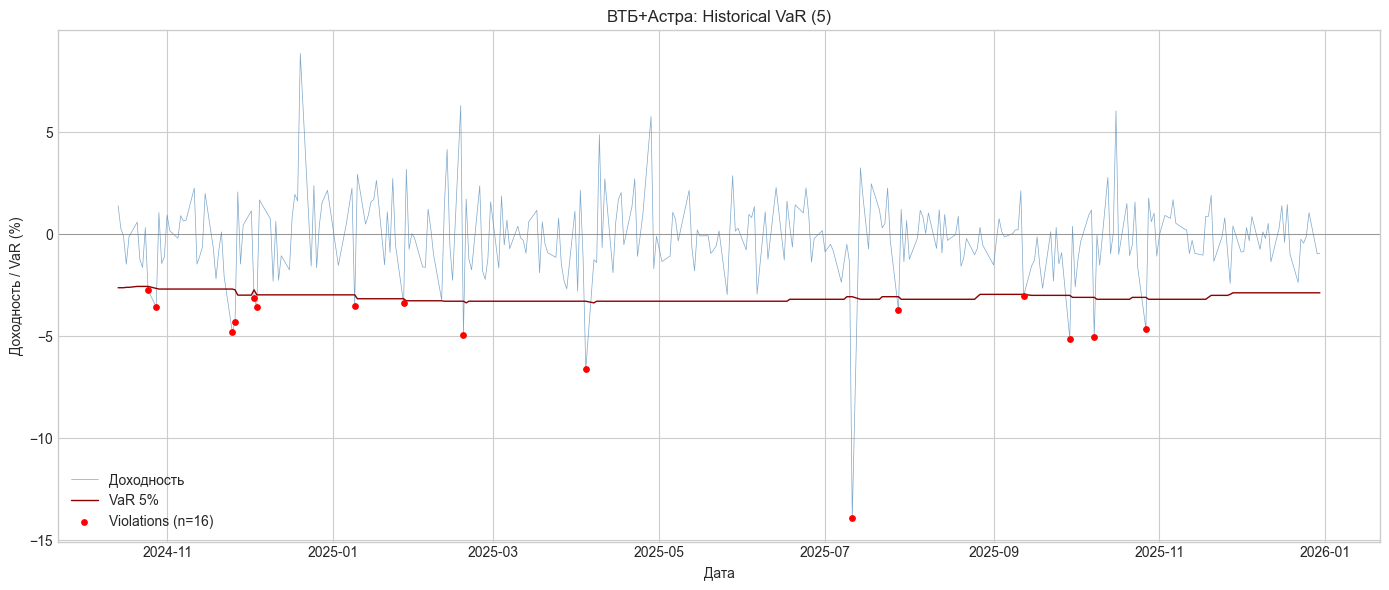


Дней: 311
Нарушений: 16
Частота: 5.14%


In [83]:
fig, ax = plt.subplots(figsize=(14, 6))
violations_port_hist = plot_var_backtest(df_port_analysis, 'VaR_hist', 
                                          'ВТБ+Астра: Historical VaR (5)', ax)
plt.tight_layout()
plt.show()

print(f"\nДней: {len(df_port_analysis)}")
print(f"Нарушений: {len(violations_port_hist)}")
print(f"Частота: {len(violations_port_hist)/len(df_port_analysis)*100:.2f}%")

In [84]:
results_port_hist = run_backtest(df_port_analysis, 'VaR_hist', confidence_level)
criteria_port_hist = calc_var_criteria(df_port_analysis, 'VaR_hist', results_port_hist['violations_df'])

print_backtest_results(results_port_hist, criteria_port_hist, 'Portfolio Historical')

BACKTEST: Portfolio Historical
Дней:                 311
Нарушений:            16
Наблюдаемая частота:  5.14%
Ожидаемая частота:    5.00%
p-value (двухсьоронний):  0.9790
Вывод: Модель Адекватна
--------------------------------------------------
Реактивность (corr):  0.0296
Стабильность (std):   0.0381%
   Средняя доходность при пробое: -4.75%
   Средний VaR при пробое:        2.95%
Отношение loss/VaR:   1.61


###### 3.2. Delta-normal (variance-covariance) approach for the portfolio with 1 year estimation period

In [88]:
window_dn = 250

# Rolling 
df_portfolio['vol_vtb'] = df_portfolio['returns_vtb'].rolling(window=window_dn).std().shift(1)
df_portfolio['vol_astra'] = df_portfolio['returns_astra'].rolling(window=window_dn).std().shift(1)

# Корреляция
df_portfolio['corr'] = df_portfolio['returns_vtb'].rolling(window=window_dn).corr(
    df_portfolio['returns_astra']
).shift(1)

print("Роллинг волатильности и корреляция (после первого года):")
print(df_portfolio[['vol_vtb', 'vol_astra', 'corr']].iloc[window_dn:].describe())

Роллинг волатильности и корреляция (после первого года):
       vol_vtb  vol_astra     corr
count 311.0000   311.0000 311.0000
mean    0.0250     0.0197   0.4744
std     0.0043     0.0012   0.0578
min     0.0178     0.0178   0.3450
25%     0.0203     0.0186   0.4224
50%     0.0263     0.0197   0.4740
75%     0.0294     0.0207   0.5255
max     0.0303     0.0240   0.5712


In [89]:
# Волатильность портфеля 
df_portfolio['vol_portfolio'] = np.sqrt(
    w_vtb**2 * df_portfolio['vol_vtb']**2 + 
    w_astra**2 * df_portfolio['vol_astra']**2 + 
    2 * w_vtb * w_astra * df_portfolio['vol_vtb'] * df_portfolio['vol_astra'] * df_portfolio['corr']
)

z_alpha = stats.norm.ppf(1 - confidence_level) 
df_portfolio['VaR_dn'] = z_alpha * df_portfolio['vol_portfolio']

df_port_analysis = df_portfolio.iloc[window_dn:].copy()

print(f"Период: {df_port_analysis.index.min().date()} - {df_port_analysis.index.max().date()}")
print(f"Дней: {len(df_port_analysis)}")
print(f"\nVaR Delta-Normal (5%):")
print(df_port_analysis['VaR_dn'].describe())

Период: 2024-10-14 - 2025-12-30
Дней: 311

VaR Delta-Normal (5%):
count   311.0000
mean      0.0317
std       0.0026
min       0.0264
25%       0.0302
50%       0.0321
75%       0.0338
max       0.0351
Name: VaR_dn, dtype: float64


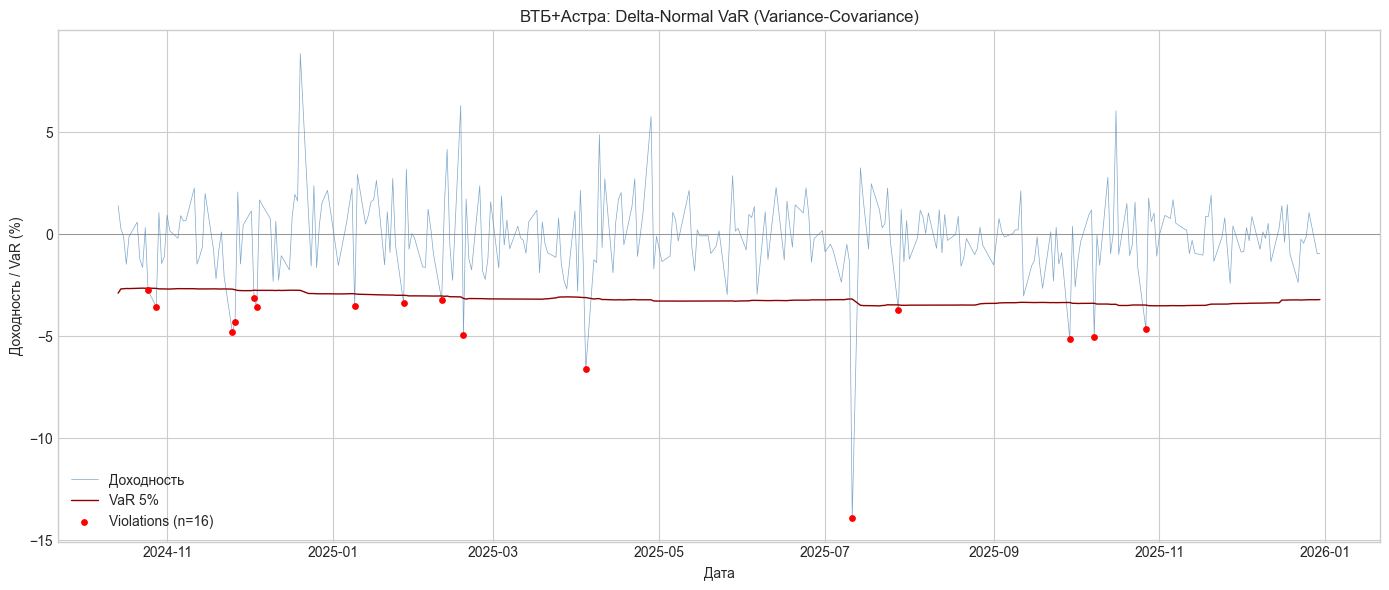


Дней: 311
Нарушений: 16
Частота: 5.14%


In [90]:
fig, ax = plt.subplots(figsize=(14, 6))
violations_port_dn = plot_var_backtest(df_port_analysis, 'VaR_dn', 
                                        'ВТБ+Астра: Delta-Normal VaR (Variance-Covariance)', ax)
plt.tight_layout()
plt.show()

print(f"\nДней: {len(df_port_analysis)}")
print(f"Нарушений: {len(violations_port_dn)}")
print(f"Частота: {len(violations_port_dn)/len(df_port_analysis)*100:.2f}%")

In [91]:
results_port_dn = run_backtest(df_port_analysis, 'VaR_dn', confidence_level)
criteria_port_dn = calc_var_criteria(df_port_analysis, 'VaR_dn', results_port_dn['violations_df'])

print_backtest_results(results_port_dn, criteria_port_dn, 'Portfolio Delta-Normal')

BACKTEST: Portfolio Delta-Normal
Дней:                 311
Нарушений:            16
Наблюдаемая частота:  5.14%
Ожидаемая частота:    5.00%
p-value (двухсьоронний):  0.9790
Вывод: Модель Адекватна
--------------------------------------------------
Реактивность (corr):  -0.1512
Стабильность (std):   0.0270%
   Средняя доходность при пробое: -4.76%
   Средний VaR при пробое:        3.01%
Отношение loss/VaR:   1.58


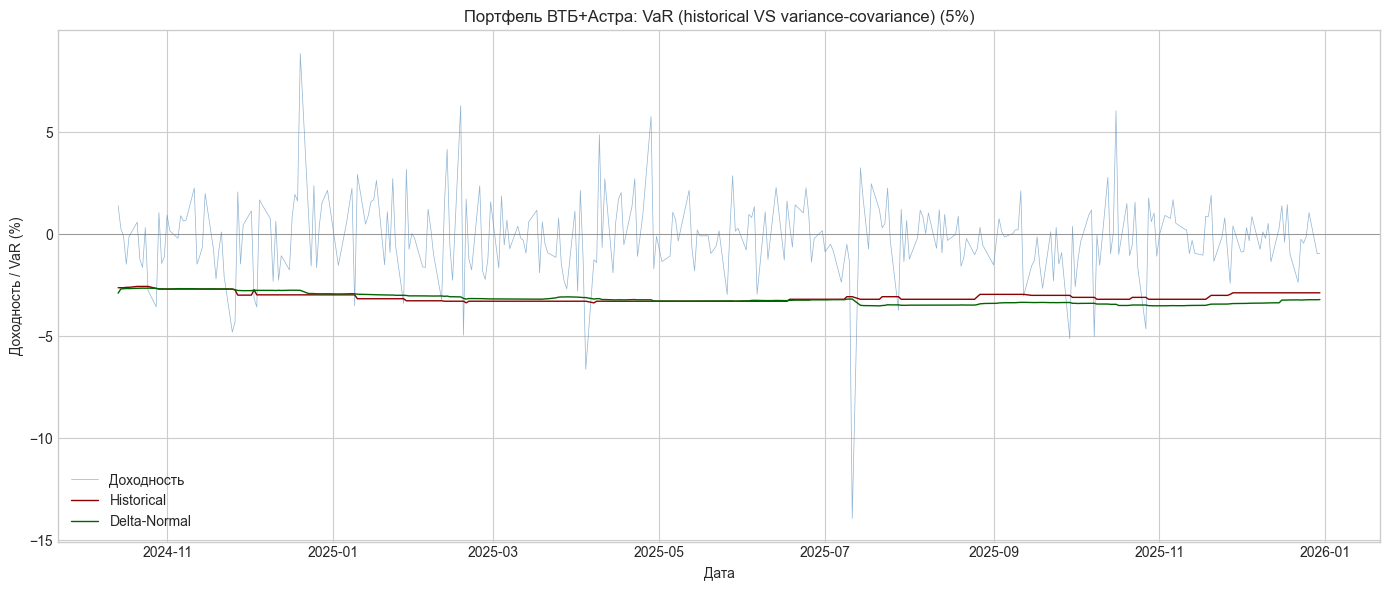

In [94]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_port_analysis.index, df_port_analysis['returns'] * 100, 
        color='steelblue', linewidth=0.5, alpha=0.6, label='Доходность')
ax.plot(df_port_analysis.index, -df_port_analysis['VaR_hist'] * 100, 
        color='darkred', linewidth=1.0, label='Historical')
ax.plot(df_port_analysis.index, -df_port_analysis['VaR_dn'] * 100, 
        color='darkgreen', linewidth=1.0, label='Delta-Normal')

ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.set_ylabel('Доходность / VaR (%)')
ax.set_xlabel('Дата')
ax.set_title('Портфель ВТБ+Астра: VaR (historical VS variance-covariance) (5%)')
ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

## TODO
##### Plot and comment the time series of returns and VaR. Discuss which VaR modeling approach you consider to be the best.
